# (Try to) identify signals of gentrification from Airbnb data

In [22]:
import os
import pandas as pd
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import Point
import sys
import seaborn as sns
import geopandas as gpd
import matplotlib as mpl
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.colors as colors

sys.path.insert(0, '../')
from PlottingFunctions import *

def dominant_and_percentage_and_count(x):
    mode_vals = pd.Series.mode(x)
    if mode_vals.empty:
        mode_val = None
        pct = 0.0
    else:
        mode_val = mode_vals.iloc[0]
        pct = (x == mode_val).mean() * 100
    count = pd.Series.count(x)
    return pd.Series({'dominant_class': mode_val, 'dominant_pct': pct, 'count': count})

cmap = plt.get_cmap('viridis', 5)  # 5 discrete colors
plot_colors = [cmap(i) for i in range(5)]
plot_colors[4] = 'gold'

city='manchester'

### Get just Manchester LSOAs

In [2]:
lsoas =  gpd.read_file('../../../data/SpatialData/LSOAs_2011/LSOA_2011_EW_BSC_V4.shp')
manc_lads = ['Manchester', 'Rochdale', 'Bolton', 'Bury', 'Wigan', 'Oldham',  'Trafford', 'Salford', 'Tameside', 'Stockport']
manc_lads_pattern = '|'.join(manc_lads)
manchester_lsoas=lsoas[lsoas['LSOA11NMW'].str.contains(manc_lads_pattern)]

manchester_lsoas = manchester_lsoas.to_crs(epsg=27700)

# Define Manchester city centre point (in WGS84, then project)
city_centre_wgs84 = Point(-2.2426, 53.4808)  # approx lat/lon of Manchester city centre
city_centre_point = gpd.GeoSeries([city_centre_wgs84], crs='EPSG:4326').to_crs(epsg=27700).iloc[0]

# Filter polygons within a buffer distance (e.g., 3 km radius)
buffer = city_centre_point.buffer(6000)  # 3000 meters
central_lsoas = manchester_lsoas[manchester_lsoas.intersects(buffer)]
central_lsoas.reset_index(inplace=True)

## Get gentrification scores for each listing

In [3]:
base_dir = os.path.expanduser(f"../../../data/AirbnbData/airbnb-{city}/")
# score_per_listing = pd.read_csv(base_dir + 'airbnb_gentrification_scores_one_per_lsoa_10.csv')
score_per_listing = pd.read_csv(base_dir + 'airbnb_gentrification_scores_new_01.csv')

mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
score_per_listing['gentrification_prediction_code'] = score_per_listing['gentrification_prediction'].map(mapping)
# Remove rows with an error
score_per_listing = score_per_listing[score_per_listing['explanation'] != 'ERROR']
score_per_listing = score_per_listing[["LSOA11NM", 'gentrification_prediction', 'explanation', 'gentrification_prediction_code', 'longitude',
                                              'latitude']]
score_per_listing['gentrification_prediction_code'] = score_per_listing['gentrification_prediction_code'].astype(int)
score_per_listing.head()

,LSOA11NM,gentrification_prediction,explanation,gentrification_prediction_code,longitude,latitude
0,Bolton 001A,Emerging,The neighborhood is described as a quiet hamle...,2,-2.450007,53.61350
1,Bolton 001A,Established,The area is described as a comfortable base fo...,4,-2.439220,53.61273
2,Bolton 001B,Emerging,The neighborhood is described as quiet and saf...,2,-2.446700,53.63582
3,Bolton 001C,Gentrifying,"The village of Egerton is described as quaint,...",3,-2.439940,53.62988
4,Bolton 002A,Established,The area of Bradshaw is described as desirable...,4,-2.395160,53.60852


### Convert to geodataframe of scores per listing, reproject to BNG

In [4]:
score_per_listing['geometry'] = score_per_listing.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
score_per_listing_gdf = gpd.GeoDataFrame(score_per_listing, geometry='geometry', crs="EPSG:4326")
score_per_listing_gdf = score_per_listing_gdf.set_crs(epsg=4326, allow_override=True)
score_per_listing_gdf = score_per_listing_gdf.to_crs(epsg=27700)
score_per_listing_gdf.head()

,LSOA11NM,gentrification_prediction,explanation,gentrification_prediction_code,longitude,latitude,geometry
0,Bolton 001A,Emerging,The neighborhood is described as a quiet hamle...,2,-2.450007,53.61350,POINT (370326.383 413088.674)
1,Bolton 001A,Established,The area is described as a comfortable base fo...,4,-2.439220,53.61273,POINT (371039.485 412998.546)
2,Bolton 001B,Emerging,The neighborhood is described as quiet and saf...,2,-2.446700,53.63582,POINT (370560.76 415570.524)
3,Bolton 001C,Gentrifying,"The village of Egerton is described as quaint,...",3,-2.439940,53.62988,POINT (371003.654 414906.877)
4,Bolton 002A,Established,The area of Bradshaw is described as desirable...,4,-2.395160,53.60852,POINT (373951.798 412513.063)


### Find which LSOA each listing is within

In [5]:
score_per_listing_with_lsoa = gpd.sjoin(
    score_per_listing_gdf,
    central_lsoas[['LSOA11NM', 'geometry']],
    how='right',
    predicate='within')

del score_per_listing_with_lsoa['LSOA11NM_left']
score_per_listing_with_lsoa.rename(columns = {'LSOA11NM_right':'LSOA11NM'}, inplace=True)
score_per_listing_with_lsoa.reset_index(inplace=True, drop=True)
score_per_listing_with_lsoa.head()

,index_left,gentrification_prediction,explanation,gentrification_prediction_code,longitude,latitude,LSOA11NM,geometry
0,406.0,Established,The description of Heaton Park as a major attr...,4.0,-2.273020,53.531710,Bury 023C,"POLYGON ((382461.689 403765.502, 382238.998 40..."
1,407.0,Gentrifying,"The description of the area as being ""just a 2...",3.0,-2.269601,53.532356,Bury 023C,"POLYGON ((382461.689 403765.502, 382238.998 40..."
2,408.0,Gentrifying,"The description of Prestwich as a ""charming ar...",3.0,-2.269350,53.532790,Bury 023C,"POLYGON ((382461.689 403765.502, 382238.998 40..."
3,409.0,Established,"The description of the area as having ""great t...",4.0,-2.271682,53.532365,Bury 023C,"POLYGON ((382461.689 403765.502, 382238.998 40..."
4,410.0,Gentrifying,The mention of Heaton Park and the fact that t...,3.0,-2.268370,53.534400,Bury 023C,"POLYGON ((382461.689 403765.502, 382238.998 40..."


### Check this spatially

## Create a dataframe with a count of the number of listings in each LSOA, and the modal score

In [11]:
per_LSOA_summary = (
    score_per_listing_with_lsoa
    .groupby("LSOA11NM")["gentrification_prediction_code"]
    .apply(dominant_and_percentage_and_count)
    .unstack()
    .reset_index())

per_LSOA_summary = central_lsoas[['LSOA11NM', 'geometry']].merge(per_LSOA_summary, on='LSOA11NM')
per_LSOA_summary = per_LSOA_summary[per_LSOA_summary['dominant_class'].notnull()]
per_LSOA_summary['dominant_class'] = per_LSOA_summary['dominant_class'].astype(int)

In [13]:
my_colors = [cmap(i) for i in range(5)]
color_map = dict(zip(range(5), colors))
score_per_listing_gdf['color']= score_per_listing_gdf['gentrification_prediction_code'].map(color_map)
score_per_listing_with_lsoa['color']= score_per_listing_with_lsoa['gentrification_prediction_code'].map(color_map)

In [18]:
# per_LSOA_summary['color'] = per_LSOA_summary['dominant_class'].map(cmap)
# colors = [cmap(i) for i in range(5)]
# color_map = dict(zip(range(5), colors))
# score_per_listing_gdf['color']= score_per_listing_gdf['gentrification_prediction_code'].map(color_map)

# fig,ax=plt.subplots(figsize=(10,10))

# # Plot using the 'color' column directly
# per_LSOA_summary_wm = per_LSOA_summary.to_crs(epsg=3857)
# per_LSOA_summary_wm.plot(color=per_LSOA_summary_wm['color'], alpha=1, ax=ax, edgecolor='black')

# score_per_listing_gdf_wm = score_per_listing_with_lsoa.to_crs(epsg=3857)
# score_per_listing_gdf_wm.plot(color=score_per_listing_gdf_wm['color'], ax=ax, legend=True, alpha=1, edgecolor='black', markersize=50);

# ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=score_per_listing_gdf_wm.crs)

# ax.axis("off");

## Plot

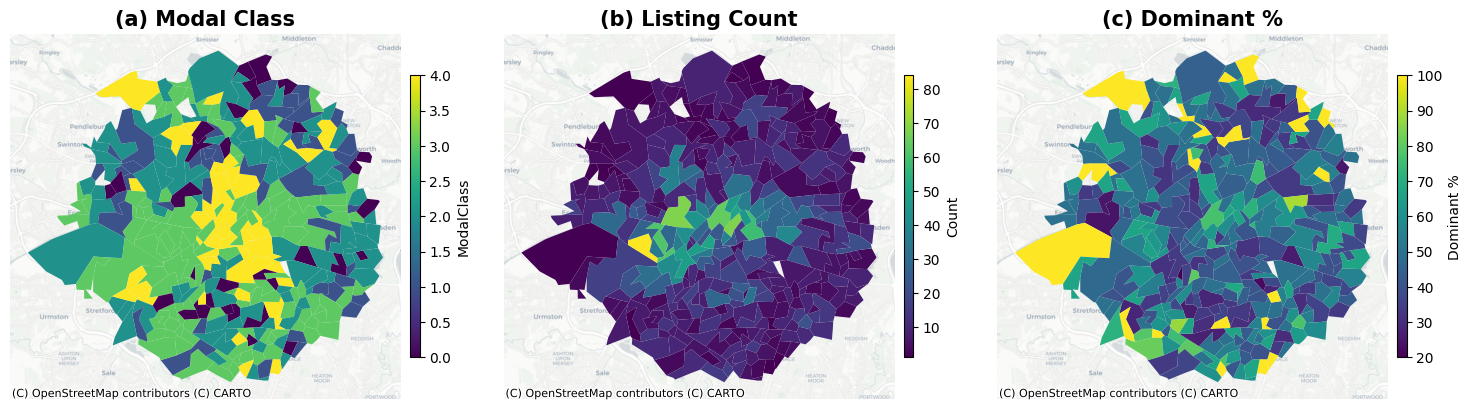

In [9]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))  # wider but flatter

# Ensure CRS is web mercator for basemap
per_LSOA_summary = per_LSOA_summary.to_crs(epsg=3857)

# Common legend keyword settings
legend_opts = {
    "shrink": 0.6,
    "orientation": "vertical",
    "pad": 0.02,
    "aspect": 30}

# Second plot: dominant class
per_LSOA_summary.plot(
    "dominant_class", alpha=1, ax=axs[0], legend=True,
    legend_kwds={"label": "ModalClass", **legend_opts})
ctx.add_basemap(axs[0], source=ctx.providers.CartoDB.Positron, crs=per_LSOA_summary.crs)
axs[0].set_title("(a) Modal Class", fontweight='bold', fontsize=15)

# First plot: count
per_LSOA_summary.plot(
    "count", alpha=1, ax=axs[1], legend=True,
    legend_kwds={"label": "Count", **legend_opts})
ctx.add_basemap(axs[1], source=ctx.providers.CartoDB.Positron, crs=per_LSOA_summary.crs)
axs[1].set_title("(b) Listing Count", fontweight='bold', fontsize=15)

# Third plot: dominant percent
per_LSOA_summary.plot(
    "dominant_pct", alpha=1, ax=axs[2], legend=True,
    legend_kwds={"label": "Dominant %", **legend_opts})
ctx.add_basemap(axs[2], source=ctx.providers.CartoDB.Positron, crs=per_LSOA_summary.crs)
axs[2].set_title("(c) Dominant %", fontweight='bold', fontsize=15)

# Tidy up
for ax in axs:
    ax.axis('off')

plt.tight_layout()
fig.savefig("../Figures/Manchester_LLM-scores.png", bbox_inches = 'tight')
plt.show()

### Gentrification index spatial plot

In [20]:
g_index = pd.read_csv("../../../data/GentrificationIndex/ManchesterIndex/manc_index.csv") 
g_index_gdf = central_lsoas[['LSOA11NM', 'geometry']].merge(g_index, on='LSOA11NM')

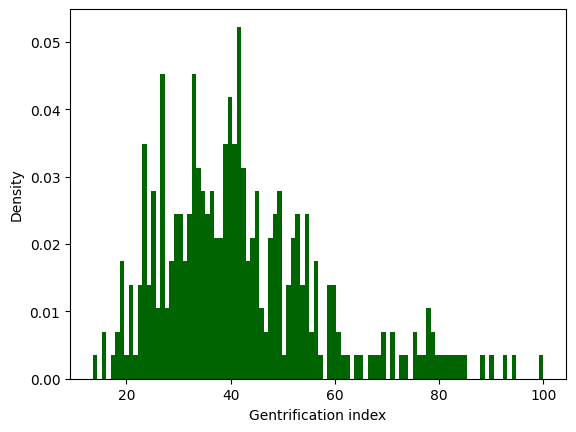

In [45]:
plt.hist(g_index_gdf['gi_n'], bins=100, color='darkgreen', density=True);
plt.ylabel('Density')
plt.xlabel('Gentrification index');
fig.savefig("../Figures/Manchester_GI_histogram.png", bbox_inches = 'tight')

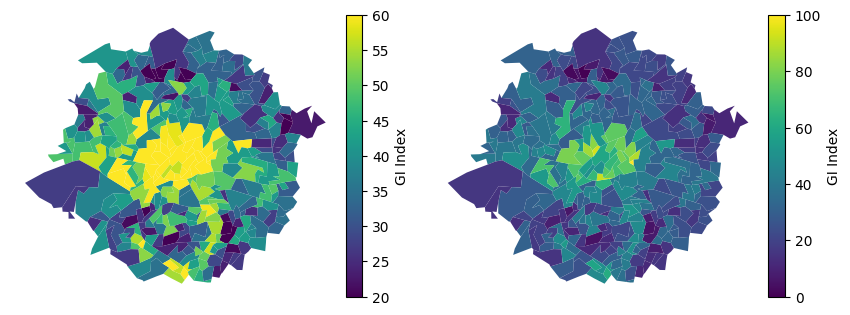

In [25]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 10), sharey=True, sharex=True)

# Plot the data
g_index_gdf.plot(column='gi_n',cmap='viridis',vmin=20,vmax=60,ax=axs[0],legend=False)

# Create divider and color axis
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)

# Create ScalarMappable for colorbar
norm = colors.Normalize(vmin=20, vmax=60)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm._A = []  # dummy array

# Add colorbar
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label("GI Index")

########### axis2
g_index_gdf.plot('gi_n', ax=axs[1])

# Create divider and color axis
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)

# Create ScalarMappable for colorbar
norm = colors.Normalize(vmin=0, vmax=100)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm._A = []  # dummy array
# Add colorbar
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label("GI Index")

axs[0].axis("off")
axs[1].axis("off");

KeyError: 'color'

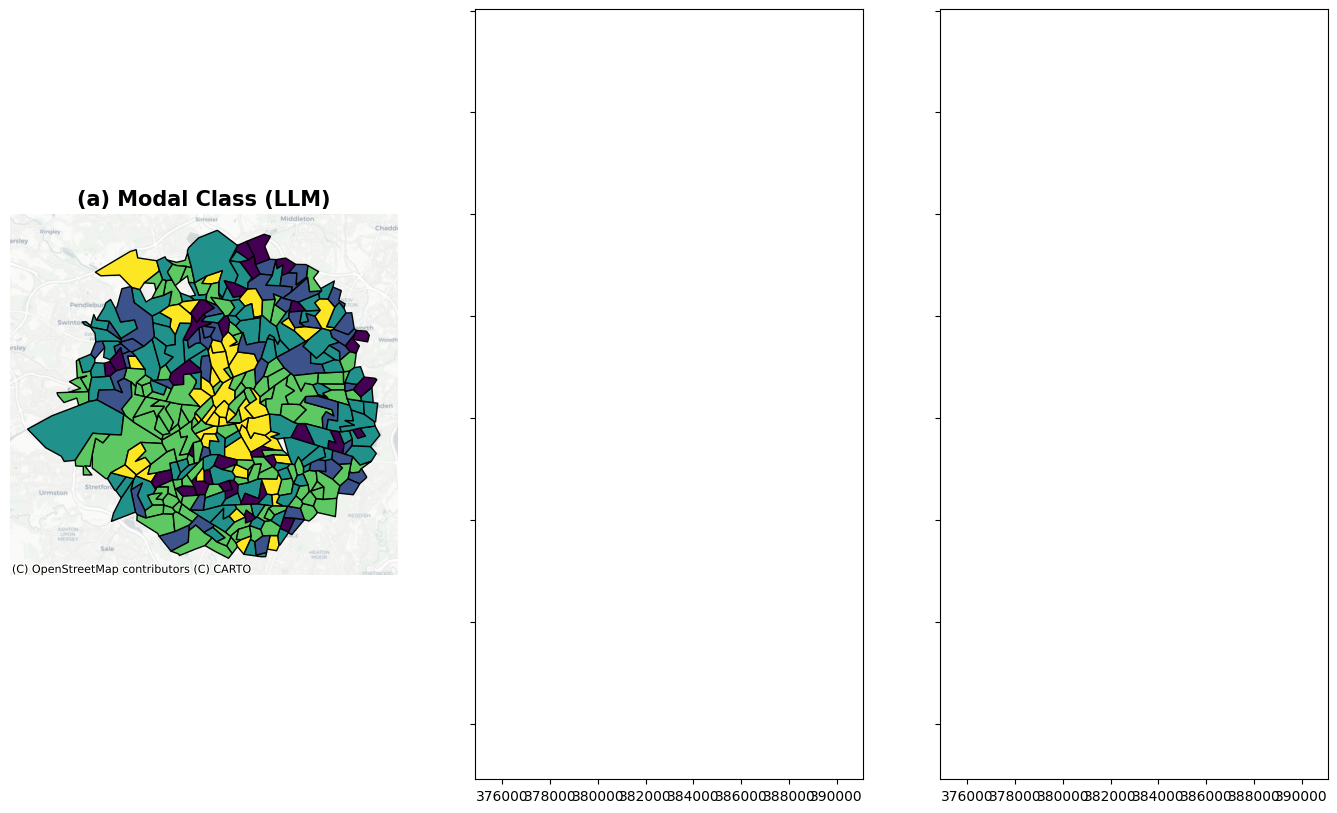

In [30]:
fig, axs = plt.subplots(ncols=3, figsize=(17, 10), sharey=True, sharex=True)

# (a) LLM map
per_LSOA_summary.plot(color=per_LSOA_summary["color"], ax=axs[0], legend=False, edgecolor='black')
ctx.add_basemap(axs[0], source=ctx.providers.CartoDB.Positron, crs=per_LSOA_summary.crs)
axs[0].set_title("(a) Modal Class (LLM)", fontweight='bold', fontsize=15)
axs[0].axis("off")

mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
class_labels = {v: k for k, v in mapping.items()}
patches_llm = [mpatches.Patch(color=per_LSOA_summary.loc[per_LSOA_summary["dominant_class"] == k, "color"].iloc[0], 
                              label=label) for k, label in class_labels.items()]

# (b) GI map
g_index_gdf.plot(color=g_index_gdf["color"], ax=axs[1], legend=False, edgecolor='black')
ctx.add_basemap(axs[1], source=ctx.providers.CartoDB.Positron, crs=g_index_gdf.crs)
axs[1].set_title("(b) GI Class", fontweight='bold', fontsize=15)
axs[1].axis("off")

mapping_idx = {1: 'Susc. to displacement', 2: "Low-income households displaced",
               4: "Early gentrification", 5: "Mixed income", 6:"Risk of exclusivity", 
               7: "Becoming exclusive", 8 : "Exclusive"}
patches_gi = [mpatches.Patch(color=g_index_gdf.loc[g_index_gdf["Classification"] == k, "color"].iloc[1], 
                             label=label) for k, label in mapping_idx.items()]

# # (c) Diff map with colorbar
# diff_plot = score_per_suburb_with_index.plot('Diff', ax=axs[2], cmap='PiYG', legend=False, edgecolor='black')
# ctx.add_basemap(axs[2], source=ctx.providers.CartoDB.Positron, crs=per_suburb_summary.crs)
# axs[2].set_title("(c) Difference", fontweight='bold', fontsize=15)
# axs[2].axis("off")

# # --- Create legends & colorbar at the bottom ---
# # 1. LLM legend
# leg1 = fig.legend(handles=patches_llm, loc='lower center', bbox_to_anchor=(0.25, 0.21),
#                   frameon=True, ncol=len(patches_llm)//2, prop={'size': 10})

# # 2. GI legend
# leg2 = fig.legend(handles=patches_gi, loc='lower center', bbox_to_anchor=(0.5, 0.19),
#                   frameon=True, ncol=2, prop={'size': 10})

# # 3. Diff colorbar (same height as legends)
# cbar_ax = fig.add_axes([0.69, 0.26, 0.19, 0.02])  # [left, bottom, width, height]
# norm = mpl.colors.Normalize(vmin=score_per_suburb_with_index['Diff'].min(), 
#                              vmax=score_per_suburb_with_index['Diff'].max())
# cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='PiYG'),
#                     cax=cbar_ax, orientation='horizontal')
# cbar.ax.tick_params(labelsize=10)

# # plt.tight_layout(rect=[0, 0.1, 1, 1])  # leave space at bottom for legends/cbar
# fig.savefig("../Figures/Melbourne_LLLM-Score_vs_GI-Score.png", bbox_inches='tight', dpi=300)